In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class Trainer(object):
    def __init__(self, net, 
                 num_epochs: int = 20,
                 learning_rate: float = 0.1,
                 weight_decay: float = 0,
                 batch_size: int = 256,
                 patience: int = -1,
                 Loss = torch.nn.CrossEntropyLoss,
                 Optim = torch.optim.SGD):
        self.net = net
        
        self.num_epochs,\
        self.learning_rate,\
        self.weight_decay,\
        self.batch_size\
        =\
        num_epochs,\
        learning_rate,\
        weight_decay,\
        batch_size
        
        self.patience = patience if patience > 0 else -1
        self.loss_fn = Loss()
        self.optimizer = Optim(self.net.parameters(),
                                 lr = self.learning_rate,
                                 weight_decay = self.weight_decay)
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": [],
        }
        
        # add cuda support
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net.to(self.device)

        
    def train(self, train_features, train_labels, test_features = None, test_labels = None):
        
        train_iter = data.DataLoader(data.TensorDataset(train_features, train_labels), self.batch_size, True)
        if test_features is not None and test_labels is not None:
            test_iter = data.DataLoader(data.TensorDataset(test_features, test_labels), self.batch_size)
    
        Plotter.set_num_epochs(self.num_epochs)
        
        best_acc:float = 0.0
        curr_patience = self.patience
        
        for epoch in range(self.num_epochs):            
            train_loss, train_acc = self.train_epoch(train_iter)
            if test_features is not None and test_labels is not None:
                test_loss, test_acc = self.evaluate(test_iter)
                
                self.history["train_loss"].append(train_loss)
                self.history["train_acc"].append(train_acc)
                self.history["test_loss"].append(test_loss)
                self.history["test_acc"].append(test_acc)
                
                Plotter.plot(self.history["train_loss"], self.history["train_acc"],
                             self.history["test_loss"], self.history["test_acc"])
                
                print(f"Epoch {epoch+1:4d} | "
                      f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                      f"test acc {test_acc:.4f}")
                
                # 提前终止
                if test_acc <= best_acc + 0.001:
                    curr_patience -= 1
                else:
                    curr_patience = self.patience
                
                if curr_patience == 0:
                    print("Not improving, breaking...")
                    break
                    
                best_acc = max(best_acc, test_acc)
                
            else:
                self.history["train_loss"].append(train_loss)
                self.history["train_acc"].append(train_acc)
                
                Plotter.plot(self.history["train_loss"], self.history["train_acc"])
                
                print(f"Epoch {epoch+1:4d} | "
                      f"train loss {train_loss:.4f} acc {train_acc:.4f}")
                
                if train_acc <= best_acc + 0.001:
                    curr_patience -= 1
                else:
                    curr_patience = self.patience
                
                if curr_patience == 0:
                    print("Not improving, breaking...")
                    break
                    
                best_acc = max(best_acc, train_acc)
            
    def train_epoch(self, loader):
        self.net.train()
        total, correct, total_loss = 0, 0, 0

        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            pred = self.net(X)
            loss = self.loss_fn(pred, y)
            loss.backward()
            self.optimizer.step()

            total += y.size(0)
            correct += (pred.argmax(1) == y).sum().item()
            total_loss += loss.item() * y.size(0)

        return total_loss/total, correct/total
    
    def evaluate(self, loader):
        self.net.eval()
        total, correct, total_loss = 0, 0, 0

        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.net(X)
                loss = self.loss_fn(pred, y)

                total += y.size(0)
                correct += (pred.argmax(1) == y).sum().item()
                total_loss += loss.item() * y.size(0)

        return total_loss/total, correct/total


In [3]:
class Plotter(object):
    num_epochs = 50
    
    @classmethod
    def set_num_epochs(cls, num_epochs):
        cls.num_epochs = num_epochs
    
    @classmethod
    def plot(cls, train_losses, train_accs, test_losses=None, test_accs=None, num_epochs=None, save_to=None):
        if not num_epochs:
            num_epochs = cls.num_epochs
        
        # refresh previous figs
        clear_output(wait=True)      
        fig, axs = plt.subplots(1, 2, figsize=(7, 2))
        loss_plt = axs[0]
        acc_plt = axs[1]
        
        loss_plt.set_xlim(1, num_epochs)
        loss_plt.set_ylim(bottom=0.0, auto=True)  # loss will always be positive
        loss_plt.set_xlabel('epoch')
        loss_plt.plot(train_losses, label="train_loss")
        if test_losses is not None:
            loss_plt.plot(test_losses, label="test_loss")
        loss_plt.legend()
        loss_plt.set_title("Loss Curve")

        acc_plt.set_xlim(1, num_epochs)
        acc_plt.set_ylim(0.0, 1.0)
        acc_plt.set_xlabel('epoch')
        acc_plt.plot(train_accs, label="train_acc")
        if test_accs is not None:
            acc_plt.plot(test_accs, label="test_acc")
        acc_plt.legend()
        acc_plt.set_title("Accuracy Curve")
        
        plt.tight_layout()
        if save_to is not None:
            plt.savefig(save_to, dpi=300)
        plt.show()
        
    @classmethod
    def save_fig(cls, trainer: Trainer, name:str = 'model', with_test=True):
        if with_test:
            cls.plot(trainer.history["train_loss"], trainer.history["train_acc"],
                     trainer.history["test_loss"], trainer.history["test_acc"],
                     num_epochs=trainer.num_epochs, save_to=OUTPUT_LOC+f"/{name}_fig.png")
        else:
            cls.plot(trainer.history["train_loss"], trainer.history["train_acc"],
                     num_epochs=trainer.num_epochs, save_to=OUTPUT_LOC+f"/{name}_fig.png")


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

def save_metrics(trainer: Trainer, name:str = 'model'):    
    df = pd.DataFrame(trainer.history)
    df.index = df.index+1
    df.to_csv(OUTPUT_LOC+f"/{name}_training_metrics.csv", index=True)

In [5]:
DATASET_LOC = '/home/iamok/D2L/CIFAR-10/cifar-10-batches-py'
OUTPUT_LOC = '/home/iamok/D2L/CIFAR-10/output'

# Load all 5 training batches
train_X_list = []
train_y_list = []

for i in range(1, 6):
    batch = unpickle(f"{DATASET_LOC}/data_batch_{i}")
    train_X_list.append(batch[b'data'])
    train_y_list.append(batch[b'labels'])

# 先用第一个 batch 小调一下超参 （初稿代码 legacy）
# X.shape = (10000, 3072)
# X = torch.tensor(train_X_list[0], dtype=torch.float32) / 255.0   # 归一化到 0~1
# y = torch.tensor(train_y_list[0], dtype=torch.long)

# Convert to torch
X = torch.tensor(np.concatenate(train_X_list, axis=0), dtype=torch.float32) / 255.0
y = torch.tensor(np.concatenate(train_y_list, axis=0), dtype=torch.long)

# 取第一个 batch （重构的代码，迫真）
X01 = X[:10000]
y01 = y[:10000]

# reshape 为 NCHW: N=batch 数, C=channel 数, HW=高宽
# 此 shape 有助于同时 handle MLP 和 CNN
X = X.reshape(-1, 3, 32, 32)

test = unpickle(DATASET_LOC+'/test_batch')

X_test = torch.tensor(test[b'data'], dtype=torch.float32) / 255.0
y_test = torch.tensor(test[b'labels'], dtype=torch.long)
X_test = X_test.reshape(-1, 3, 32, 32)



In [6]:
def xavier_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         nn.init.normal_(m.weight, mean=0, std=np.sqrt(2/(m.in_features+m.out_features)))
# To support Conv2d initialiazation on gpu, use torch api to init
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_net(net: nn.Sequential, use_xavier: bool = True) -> nn.Sequential:
    if use_xavier:
        net.apply(xavier_init)
    else:
        pass
    return net
        

In [7]:
in_size = 3*32*32
out_size = 10

In [8]:
# sfm_net = init_net(nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(in_size, out_size)
# ))

# mlp_first_net = init_net(nn.Sequential(
#     nn.Flatten(),                             
#     nn.Linear(in_size, 3*32), nn.ReLU(), nn.Dropout(0),
#     nn.Linear(3*32, out_size)
# ))

# mlp_final_net = init_net(nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(in_size, 1024), nn.ReLU(), nn.Dropout(0.2),
#     nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.2),
#     nn.Linear(512, 256), nn.ReLU(),
#     nn.Linear(256, out_size)
# ))

# cnn1_net = init_net(nn.Sequential(
#     nn.Conv2d(3, 64, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(64, 32, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

#     nn.Flatten(),
#     nn.Linear(32*16*16, 256),
#     nn.ReLU(),
#     nn.Linear(256, out_size)
# ))

# cnn2_net = init_net(nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (3,32,32) to (32,32,32)
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2),                             # to (32,16,16)

#     nn.Conv2d(32, 64, kernel_size=3, padding=1), # to (64,16,16)
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(2),                             # to (64,8,8)

#     nn.Flatten(),                                # to (4096)
#     nn.Linear(64*8*8, 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256, out_size)
# ))

cnn3_net = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),    # (64,16,16)

    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),    # (64,8,8)

    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),    # (128,4,4)

    nn.Flatten(),
    nn.Linear(128*4*4, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, out_size)
)


In [9]:
# sfm_trainer = Trainer(sfm_net)

# mlp_first_trainer = Trainer(mlp_first_net, num_epochs=50)

# mlp_final_trainer = Trainer(
#     mlp_final_net,
#     learning_rate=1e-3,
#     num_epochs=50,
#     Optim = torch.optim.Adam,
#     weight_decay=1e-4
# )

# cnn1_trainer = Trainer(
#     cnn1_net,
#     learning_rate=1e-3,
#     num_epochs=50,
#     Optim=torch.optim.Adam,
#     weight_decay=5e-4
# )

# cnn2_trainer = Trainer(
#     cnn2_net,
#     learning_rate=1e-3,
#     num_epochs=50,
#     Optim=torch.optim.Adam,
#     weight_decay=5e-4
# )

cnn3_trainer = Trainer(
    cnn3_net,
    learning_rate=5e-4,
    num_epochs=100,
    Optim=torch.optim.Adam,
    weight_decay=1e-3,
    batch_size=128,
    patience=10
)

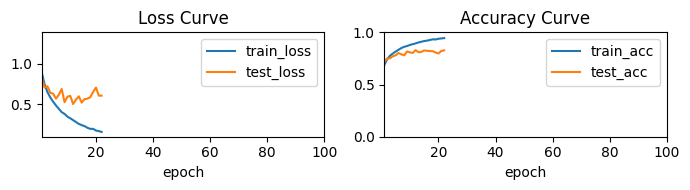

Epoch   23 | train loss 0.1585 acc 0.9448 | test acc 0.8271
Not improving, breaking...


In [10]:
# sfm_trainer.train(X, y)
# mlp_first_trainer.train(X01, y01, X_test, y_test)
# mlp_final_trainer.train(X, y, X_test, y_test)
# cnn1_trainer.train(X, y, X_test, y_test)
# cnn2_trainer.train(X, y, X_test, y_test)
cnn3_trainer.train(X, y, X_test, y_test)

将训练 metrics 导出为 csv

In [11]:
# save_metrics(sfm_trainer, 'sfm', False)
# save_metrics(mlp_first_trainer, 'mlp_first')
# save_metrics(mlp_final_trainer, 'mlp_final')
# save_metrics(cnn1_trainer, 'cnn1')
# save_metrics(cnn2_trainer, 'cnn2')
save_metrics(cnn3_trainer, 'cnn3')

导出 matplotlib 图片

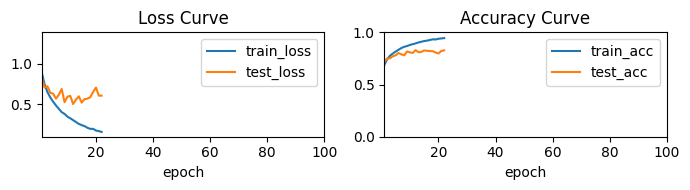

In [12]:
# Plotter.save_fig(sfm_trainer, 'sfm', False)
# Plotter.save_fig(mlp_first_trainer, 'mlp_first')
# Plotter.save_fig(mlp_final_trainer, 'mlp_final')
# Plotter.save_fig(cnn1_trainer, 'cnn1')
# Plotter.save_fig(cnn2_trainer, 'cnn2')
Plotter.save_fig(cnn3_trainer, 'cnn3')

导出 net 为 pth

In [13]:
# torch.save(mlp_first_net.state_dict(), OUTPUT_LOC+"/mlp_first.pth")
# torch.save(mlp_final_net.state_dict(), OUTPUT_LOC+"/mlp_final.pth")
# torch.save(cnn1_net.state_dict(), OUTPUT_LOC + "/cnn1.pth")
# torch.save(cnn2_net.state_dict(), OUTPUT_LOC + "/cnn2.pth")
torch.save(cnn3_net.state_dict(), OUTPUT_LOC + "/cnn3.pth")

加载导出的 pth

In [14]:
# mlp_net.load_state_dict(torch.load("mlp_cifar10.pth"))
# mlp_net.eval()
